In [1]:
#import tensorflow as tf
#!pip install tensorflow==2.16.1
import tensorflow as tf
tf.__version__

'2.16.1'

In [14]:
import os
import numpy as np
import pandas as pd
import math
import datetime as dt

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Dense, LSTM, Bidirectional, TimeDistributed
from tensorflow.keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt
from itertools import cycle
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score
from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance, accuracy_score
from sklearn.preprocessing import MinMaxScaler
import yfinance as yf
from datetime import date
import datetime as dt
from datetime import timedelta

In [8]:
def remove(x):
    """
    This function will strip the data column of the dataframe.
    """
    x = str(x)
    res = x.split(" ")[0]
    return res

def load_dataset():
    btc = yf.Ticker("BTC-USD")
    btc = btc.history(period="max")  # we want the max data avialable
    btc.index = pd.to_datetime(btc.index)  # changing the index
    btc.index = btc.index.to_series().apply(lambda x:remove(x))  # applying preprocessing function
    btc.to_csv('BTC_USD.csv')  # saving the data in csv format
    return btc

In [9]:
def preprocess_data(maindf, train_end_date, start_date):
    maindf = maindf.reset_index()
    maindf['Date'] = pd.to_datetime(maindf['Date'], format='%Y-%m-%d')
    maindf = maindf.drop(columns=['Open','Volume', 'Dividends', 'Stock Splits'])
    maindf = maindf.loc[(maindf['Date'] >= start_date)]
    maindf = maindf.reset_index(drop=True)
    train_data = maindf[maindf['Date'] < train_end_date]
    test_data = maindf[maindf['Date'] >= train_end_date]
    train_data = train_data.drop(columns=['Date'])
    test_data = test_data.drop(columns=['Date'])
    scaler=MinMaxScaler(feature_range=(-1,1))
    train_data[['Close','Low','High']]=scaler.fit_transform(train_data[['Close','Low','High']])
    test_data[['Close','Low','High',]]=scaler.transform(test_data[['Close','Low','High']])

    return scaler, train_data, test_data

def create_dataset_df(dataset, time_step):
  X = []
  y=[]
  for i in range(len(dataset) - time_step):
    # Select the last 15 days
    X.append(dataset[['Close','Low','High']].iloc[i:i+time_step])
    # Select the 16th day as the target
    y.append(dataset[['Close','Low','High']].iloc[i+time_step].values)
  return np.array(X),np.array(y)

def create_model_1():
    model=Sequential()

    model.add(LSTM(16, input_shape=(None,3)))
    model.add(Dropout(0.2))
    model.add(Dense(3))

    model.compile(loss="mean_squared_error",optimizer="adam")

    return model

def create_model_2():
    model=Sequential()

    model.add(LSTM(32, return_sequences=True, input_shape=(None,3)))
    model.add(Dropout(0.2))
    model.add(LSTM(8))
    model.add(Dropout(0.2))
    model.add(Dense(3))

    model.compile(loss="mean_squared_error",optimizer="adam")

    return model

def create_model_3():
    model=Sequential()

    model.add(LSTM(8, return_sequences=True, input_shape=(None,3)))
    model.add(Dropout(0.2))
    model.add(LSTM(4))
    model.add(Dropout(0.2))
    model.add(Dense(3))

    model.compile(loss="mean_squared_error",optimizer="adam")

    return model

In [12]:
def build_models(start_date, train_end_date, time_step):
  data = load_dataset()
  scaler, train_data, test_data = preprocess_data(data, train_end_date, start_date)
  X_train, y_train = create_dataset_df(train_data, time_step)
  X_test, y_test = create_dataset_df(test_data, time_step)
  model_1 = create_model_1()
  model_2 = create_model_2()
  model_3 = create_model_3()
  history_1 = model_1.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=200,batch_size=32,verbose=1, shuffle= False, callbacks = [EarlyStopping(monitor='val_loss', min_delta=5e-5, patience=20, verbose=1)])
  history_2 = model_2.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=200,batch_size=32,verbose=1, shuffle= False, callbacks = [EarlyStopping(monitor='val_loss', min_delta=5e-5, patience=20, verbose=1)])
  history_3 = model_3.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=200,batch_size=32,verbose=1, shuffle= False, callbacks = [EarlyStopping(monitor='val_loss', min_delta=5e-5, patience=20, verbose=1)])
  eval_1 = evaluate_model(scaler, model_1, X_train, y_train, X_test, y_test)
  eval_2 = evaluate_model(scaler, model_2, X_train, y_train, X_test, y_test)
  eval_3 = evaluate_model(scaler, model_3, X_train, y_train, X_test, y_test)
  return history_1, history_2, history_3, model_1, model_2, model_3, eval_1, eval_2, eval_3

def plot_history(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(loss))
    plt.plot(epochs, loss, 'r', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend(loc=0)
    plt.figure()
    plt.show()

def evaluate_model(scaler, model, X_train, y_train, X_test, y_test):
    train_predict = model.predict(X_train)
    test_predict = model.predict(X_test)
    train_predict = scaler.inverse_transform(train_predict)
    test_predict = scaler.inverse_transform(test_predict)
    original_ytrain = scaler.inverse_transform(y_train)
    original_ytest = scaler.inverse_transform(y_test)
    rmse_train, rmse_test = [], []
    r2_train, r2_test = [], []
    for i in range(3):
      rmse_train.append(math.sqrt(mean_squared_error(original_ytrain[:,i],train_predict[:,i])))
      rmse_test.append(math.sqrt(mean_squared_error(original_ytest[:,i],test_predict[:,i])))
      r2_train.append(r2_score(original_ytrain[:,i], train_predict[:,i]))
      r2_test.append(r2_score(original_ytest[:,i], test_predict[:,i]))

    data = {
      'close': [rmse_train[0], rmse_test[0],  r2_train[0], r2_test[0] ],
      'low': [rmse_train[1], rmse_test[1],  r2_train[1], r2_test[1]],
      'high': [rmse_train[2], rmse_test[2], r2_train[2], r2_test[2]]
    }

    index = ['rmse_train', 'rmse_test', 'r2_train', 'r2_test']

    model_eval_df = pd.DataFrame(data, index=index)
    return model_eval_df

# Model Evaluation Analysis



1.   Training Data = From 2014-09-17 to 2024-01-01
2.   Test Data = From 2024-01-01 to 2024-05-17
3.   Time Step = 15 (i.e. considering last 15 days to predict next day) [link text](https://)



/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
106/106 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.4561 - val_loss: 0.2730
Epoch 2/200
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0493 - val_loss: 0.1234
Epoch 3/200
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0354 - val_loss: 0.0671
Epoch 4/200
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0310 - val_loss: 0.0514
Epoch 5/200
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0280 - val_loss: 0.0360
Epoch 6/200
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0256 - val_loss: 0.0287
Epoch 7/200
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0240 - val_loss: 0.0245
Epoch 8/200
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0221 - val_loss: 0.0187
Epoch 9/200
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0223 - val_loss: 0.0217
Epoch 10/200
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0195 - val_loss: 0.0138
Epoch 11/200
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0177 - val_loss: 0.0182
Epoch 12/200
106/106 ━━━━━━━━━━━━━━━━━━━━

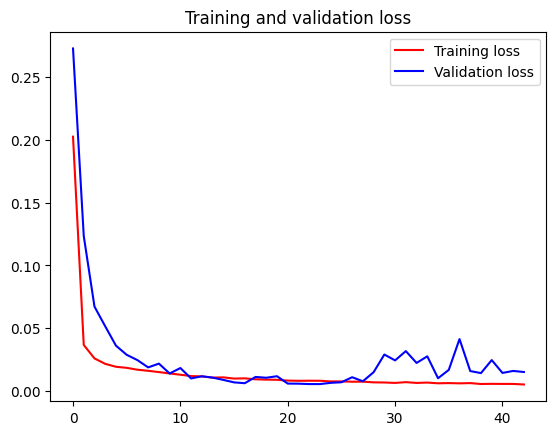

<Figure size 640x480 with 0 Axes>

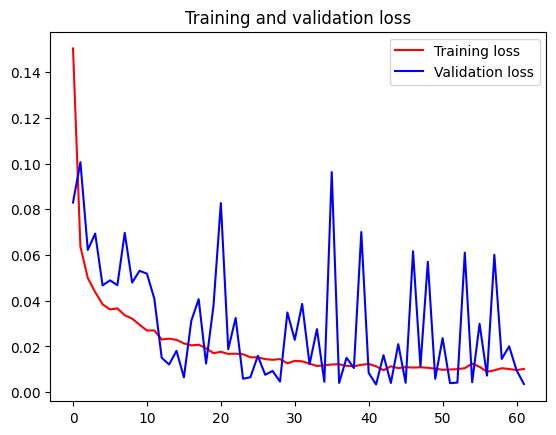

<Figure size 640x480 with 0 Axes>

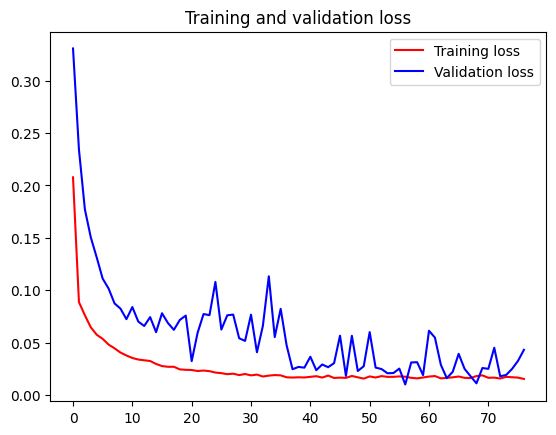

<Figure size 640x480 with 0 Axes>

(                  close          low         high
 rmse_train  1426.015013  1401.833090  1270.341319
 rmse_test   4473.853257  4012.138822  3849.538726
 r2_train       0.992247     0.992086     0.994130
 r2_test        0.804459     0.827909     0.866055,
                   close          low         high
 rmse_train  1980.795974  1873.162079  1832.089227
 rmse_test   2431.262946  1848.892044  1684.167390
 r2_train       0.985040     0.985869     0.987792
 r2_test        0.942252     0.963455     0.974362,
                   close          low         high
 rmse_train  2656.599474  2565.012498  2634.563256
 rmse_test   7137.275365  6854.168370  6991.775369
 r2_train       0.973091     0.973502     0.974755
 r2_test        0.502333     0.497754     0.558141)

In [13]:
start_date = '2014-09-17'
train_end_date = '2024-01-01'
np.random.seed(42)
tf.random.set_seed(42)
time_step = 15
history_1, history_2, history_3, model_1, model_2, model_3, eval_1, eval_2, eval_3 = build_models(start_date, train_end_date, time_step)
plot_history(history_1)
plot_history(history_2)
plot_history(history_3)
model_1.save('model_1.keras')
model_2.save('model_2.keras')
model_3.save('model_3.keras')

eval_1, eval_2, eval_3

In [18]:
dataset = 'BTC_USD.csv'
btc = pd.read_csv(dataset)
btc = btc.reset_index()
btc['Date'] = pd.to_datetime(btc['Date'], format='%Y-%m-%d')
closedf = btc[['Date','Close','Low','High']]
closedf = closedf[closedf['Date'] <= '2024-05-17']
closedf = closedf.reset_index(drop=True)
scaler=MinMaxScaler(feature_range=(-1,1))
closedf[['Close','Low', 'High']]=scaler.fit_transform(closedf[['Close','Low','High']])

def get_past_data(time_step, input_date):
    date_object = dt.datetime.strptime(input_date, '%Y-%m-%d').date()
    start_window = date_object - timedelta(days=time_step)
    input_for_prediction = closedf[(closedf['Date'] > str(start_window)) & (closedf['Date'] <= str(date_object))]
    i = int(closedf.index[closedf['Date'] == str(start_window)].tolist()[0])
    X = []
    X.append(closedf[['Close','Low','High']].iloc[i+1:i+time_step+1])
    return np.array(X)

def predict_next_cycle(time_step, model, input_for_prediction, cycleLength):
  result=[]
  for i in range(cycleLength):
    if(i != 0):
      array_reshaped = input_for_prediction.reshape(time_step, 3)
      array_appended = np.vstack([array_reshaped, predicted_value])
      array_final = array_appended[1:]
      input_for_prediction = array_final.reshape(1, time_step, 3)
    predicted_value = model.predict(input_for_prediction)
    ans = scaler.inverse_transform(predicted_value)
    result.append(str(ans[0]))
  return result

def predict_next_7_days(time_step, model, input_date):
    input_for_prediction = get_past_data(time_step, input_date)
    result = predict_next_cycle(time_step, model, input_for_prediction, 7)
    return result

time_step = 15
date = '2024-04-10'
result = predict_next_7_days(time_step, model_1, date)

result

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


['[65593.3   63817.34  67118.125]',
 '[64157.44  61908.723 65192.418]',
 '[62569.785 60000.28  63259.508]',
 '[60825.53  58054.207 61282.098]',
 '[58977.69  56089.785 59277.156]',
 '[57075.36  54130.402 57263.89 ]',
 '[55140.566 52189.84  55257.312]']

In [20]:
time_step = 15
date = '2024-04-10'
result = predict_next_7_days(time_step, model_2, date)

result

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


['[68982.89 67533.08 70956.23]',
 '[68515.65 67064.67 70457.9 ]',
 '[68100.164 66657.55  70024.766]',
 '[67788.11  66356.33  69704.164]',
 '[67575.48  66152.336 69487.23 ]',
 '[67436.12 66017.84 69344.81]',
 '[67337.016 65920.414 69242.26 ]']

In [21]:
date = '2024-04-10'
result = predict_next_7_days(time_step, model_3, date)

result

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


['[62490.15  60490.5   63455.156]',
 '[60845.13  58899.08  61779.586]',
 '[59011.812 57126.11  59912.79 ]',
 '[57174.977 55350.055 58043.062]',
 '[55363.938 53599.1   56200.14 ]',
 '[53583.258 51877.566 54388.582]',
 '[51834.383 50186.777 52609.89 ]']

# Model Evaluation Analysis with reduced data

1.   Training Data = From 2020-01-01 to 2024-01-01
2.   Test Data = From 2024-01-01 to 2024-05-17
3.   Time Step = 15 (i.e. considering last 15 days to predict next day)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.6516 - val_loss: 0.4700
Epoch 2/200
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2504 - val_loss: 0.2785
Epoch 3/200
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0868 - val_loss: 0.1863
Epoch 4/200
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0589 - val_loss: 0.1412
Epoch 5/200
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0403 - val_loss: 0.1174
Epoch 6/200
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0381 - val_loss: 0.1035
Epoch 7/200
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0306 - val_loss: 0.0877
Epoch 8/200
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0253 - val_loss: 0.0744
Epoch 9/200
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0262 - val_loss: 0.0634
Epoch 10/200
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0229 - val_loss: 0.0521
Epoch 11/200
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0225 - val_loss: 0.0460
Epoch 12/200
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0

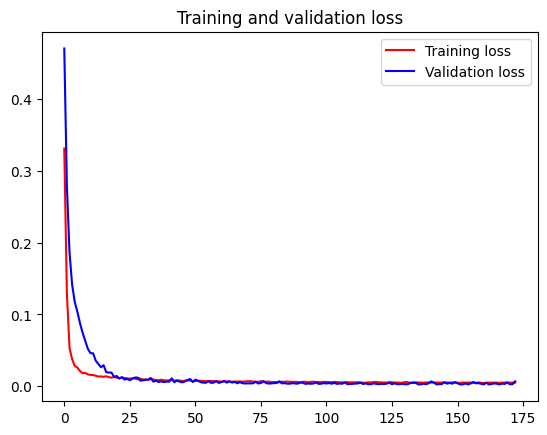

<Figure size 640x480 with 0 Axes>

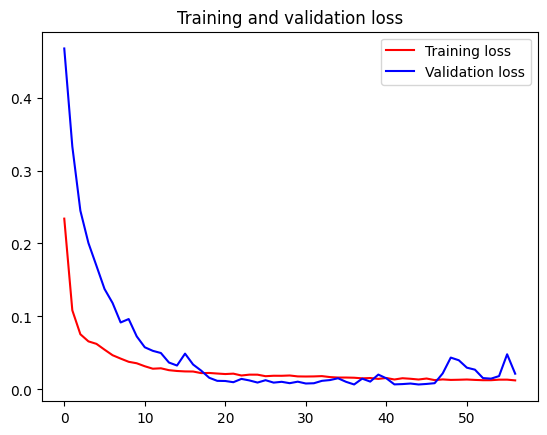

<Figure size 640x480 with 0 Axes>

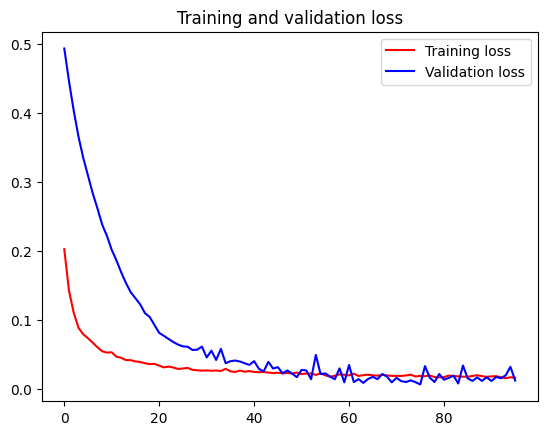

<Figure size 640x480 with 0 Axes>

(                  close          low         high
 rmse_train  1425.395686  1235.198596  1182.732848
 rmse_test   2855.846574  2447.590677  2411.535382
 r2_train       0.991011     0.992822     0.994132
 r2_test        0.920324     0.935955     0.947435,
                   close          low         high
 rmse_train  2070.511591  1730.725034  1800.728984
 rmse_test   4994.688032  4022.434298  4744.245697
 r2_train       0.981033     0.985908     0.986398
 r2_test        0.756291     0.827024     0.796557,
                   close          low         high
 rmse_train  1839.633589  1750.073484  1652.686269
 rmse_test   3559.644609  3367.399239  3456.563417
 r2_train       0.985027     0.985591     0.988543
 r2_test        0.876215     0.878774     0.892006)

In [22]:
start_date = '2020-01-01'
train_end_date = '2024-01-01'
np.random.seed(42)
tf.random.set_seed(42)
time_step = 15
history_1, history_2, history_3, model_1, model_2, model_3, eval_1, eval_2, eval_3 = build_models(start_date, train_end_date, time_step)
plot_history(history_1)
plot_history(history_2)
plot_history(history_3)
model_1.save('model_1_reduced.keras')
model_2.save('model_2_reduced.keras')
model_3.save('model_3_reduced.keras')

eval_1, eval_2, eval_3

In [23]:
time_step = 15
date = '2024-04-10'
result = predict_next_7_days(time_step, model_1, date)

result

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


['[67467.11  65444.844 68507.08 ]',
 '[65127.6   63210.027 66083.016]',
 '[62723.484 60920.242 63602.383]',
 '[60382.555 58690.64  61194.99 ]',
 '[58164.11 56575.35 58919.31]',
 '[56090.32  54595.715 56795.96 ]',
 '[54162.438 52753.13  54825.28 ]']

In [24]:
time_step = 15
date = '2024-04-10'
result = predict_next_7_days(time_step, model_2, date)

result

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


['[65122.39  64126.152 66270.7  ]',
 '[64138.41  63047.81  64969.867]',
 '[62491.75 61427.62 63082.19]',
 '[60446.91  59494.758 60930.016]',
 '[58232.484 57444.836 58743.26 ]',
 '[56011.01  55416.72  56654.387]',
 '[53927.312 53524.13  54770.074]']

In [25]:
time_step = 15
date = '2024-04-10'
result = predict_next_7_days(time_step, model_3, date)

result

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


['[67163.85 65003.53 67873.82]',
 '[66569.82 64406.41 67265.59]',
 '[65682.03  63520.516 66380.84 ]',
 '[64658.367 62512.633 65372.086]',
 '[63598.156 61476.32  64330.957]',
 '[62543.707 60451.33  63296.105]',
 '[61507.61  59448.508 62278.42 ]']

# Model Evaluation Analysis with timestep 30



1.   Training Data = From 2014-09-17 to 2024-01-01
2.   Test Data = From 2024-01-01 to 2024-05-17
3.   Time Step = 15 (i.e. considering last 15 days to predict next day)



/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
106/106 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.5798 - val_loss: 0.1807
Epoch 2/200
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0943 - val_loss: 0.1023
Epoch 3/200
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0608 - val_loss: 0.0660
Epoch 4/200
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0463 - val_loss: 0.0486
Epoch 5/200
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0393 - val_loss: 0.0355
Epoch 6/200
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0321 - val_loss: 0.0351
Epoch 7/200
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0301 - val_loss: 0.0260
Epoch 8/200
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0268 - val_loss: 0.0232
Epoch 9/200
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0247 - val_loss: 0.0213
Epoch 10/200
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0237 - val_loss: 0.0165
Epoch 11/200
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0202 - val_loss: 0.0228
Epoch 12/200
106/106 ━━━━━━━━━━━━━━━━━━━━

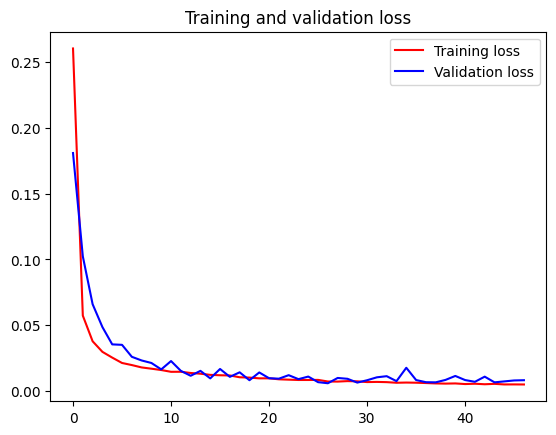

<Figure size 640x480 with 0 Axes>

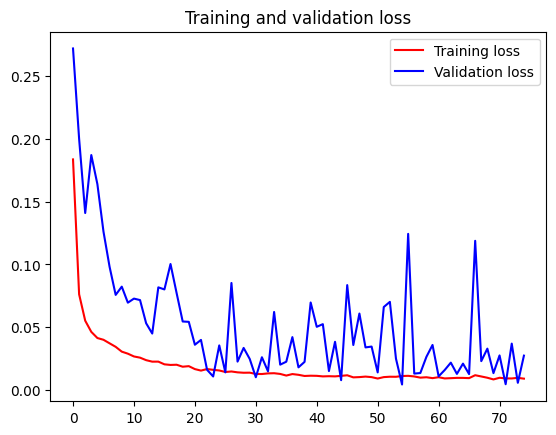

<Figure size 640x480 with 0 Axes>

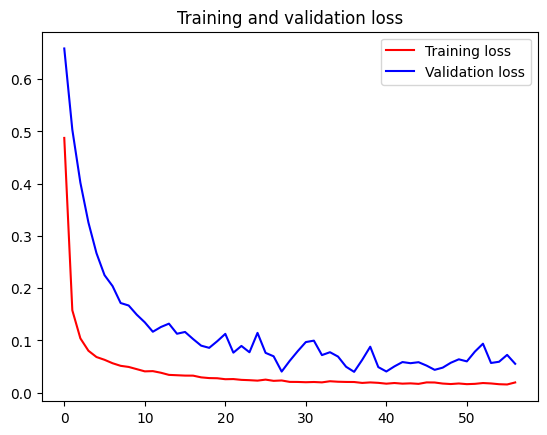

<Figure size 640x480 with 0 Axes>

(                  close          low         high
 rmse_train  1627.839122  1460.060633  1197.703471
 rmse_test   3712.197876  2737.860267  2611.474455
 r2_train       0.989907     0.991423     0.994788
 r2_test        0.799074     0.880730     0.909058,
                   close          low         high
 rmse_train  2403.363729  2316.262185  2392.481478
 rmse_test   5600.326417  5712.431510  5416.540521
 r2_train       0.977998     0.978413     0.979202
 r2_test        0.542702     0.480782     0.608766,
                   close          low         high
 rmse_train  2949.849435  2831.643735  2966.489152
 rmse_test   8059.703402  7724.917412  8009.259457
 r2_train       0.966855     0.967738     0.968024
 r2_test        0.052867     0.050498     0.144585)

In [26]:
start_date = '2014-09-17'
train_end_date = '2024-01-01'
np.random.seed(42)
tf.random.set_seed(42)
time_step = 30
history_1, history_2, history_3, model_1, model_2, model_3, eval_1, eval_2, eval_3 = build_models(start_date, train_end_date, time_step)
plot_history(history_1)
plot_history(history_2)
plot_history(history_3)
model_1.save('model_1.keras')
model_2.save('model_2.keras')
model_3.save('model_3.keras')

eval_1, eval_2, eval_3

In [27]:
time_step = 30
date1 = '2024-04-21'
date2 = '2024-04-28'
date3 = '2024-05-05'
result1 = predict_next_7_days(time_step, model_1, date1)
result2 = predict_next_7_days(time_step, model_1, date2)
result3 = predict_next_7_days(time_step, model_1, date3)

result1, result2, result3

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


(['[62158.023 60842.277 63906.246]',
  '[61425.773 59907.617 63124.49 ]',
  '[60660.89  59038.156 62297.836]',
  '[59877.977 58185.62  61458.58 ]',
  '[59077.496 57341.574 60606.69 ]',
  '[58267.715 56506.695 59749.57 ]',
  '[57454.094 55681.496 58892.375]'],
 ['[61733.945 60093.027 63220.37 ]',
  '[60903.973 59180.44  62403.555]',
  '[60067.906 58304.92  61555.457]',
  '[59231.434 57445.227 60697.004]',
  '[58394.598 56597.49  59832.777]',
  '[57560.344 55761.527 58968.54 ]',
  '[56730.914 54937.418 58108.38 ]'],
 ['[60858.63  59689.445 62590.46 ]',
  '[60236.035 58828.547 61918.316]',
  '[59563.734 58029.016 61181.918]',
  '[58858.938 57237.35  60418.465]',
  '[58124.227 56446.227 59630.3  ]',
  '[57370.56  55657.902 58827.51 ]',
  '[56605.38  54874.05  58017.277]'])

In [28]:
result1 = predict_next_7_days(time_step, model_2, date1)
result2 = predict_next_7_days(time_step, model_2, date2)
result3 = predict_next_7_days(time_step, model_2, date3)

result1, result2, result3

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


(['[60746.86  58290.613 61660.742]',
  '[58734.797 56504.3   59602.52 ]',
  '[56092.55  54044.992 56910.58 ]',
  '[53495.664 51562.92  54273.547]',
  '[51151.945 49287.934 51900.5  ]',
  '[49045.758 47235.664 49771.246]',
  '[47097.59  45346.4   47802.004]'],
 ['[59612.51  57271.38  60498.656]',
  '[57682.348 55506.875 58530.543]',
  '[55290.348 53257.07  56097.88 ]',
  '[52899.445 50966.4   53672.2  ]',
  '[50666.42  48805.06  51411.387]',
  '[48595.8   46797.69  49317.152]',
  '[46643.96  44913.55  47343.094]'],
 ['[60138.438 57682.67  61051.934]',
  '[58263.242 56056.637 59128.88 ]',
  '[55579.688 53574.938 56391.703]',
  '[52912.14  51029.457 53681.13 ]',
  '[50525.18  48709.777 51263.594]',
  '[48411.07  46644.312 49126.223]',
  '[46480.824 44767.227 47175.16 ]'])

In [29]:
result1 = predict_next_7_days(time_step, model_3, date1)
result2 = predict_next_7_days(time_step, model_3, date2)
result3 = predict_next_7_days(time_step, model_3, date3)

result1, result2, result3

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


(['[57478.066 55735.047 58245.727]',
  '[56641.78 54963.97 57377.13]',
  '[55367.492 53767.27  56065.746]',
  '[53847.918 52330.24  54508.227]',
  '[52166.566 50733.    52789.51 ]',
  '[50377.215 49026.85  50964.395]',
  '[48518.55 47248.91 49072.16]'],
 ['[58144.98  56373.453 58917.754]',
  '[57050.223 55356.81  57785.754]',
  '[55634.516 54025.26  56331.01 ]',
  '[54032.477 52509.36  54690.26 ]',
  '[52303.15  50866.008 52923.426]',
  '[50485.36  49132.492 51069.945]',
  '[48609.46  47337.953 49160.676]'],
 ['[55950.64  54255.48  56692.355]',
  '[55261.92  53625.855 55974.52 ]',
  '[54074.027 52512.16  54751.56 ]',
  '[52605.32  51123.676 53246.59 ]',
  '[50955.426 49555.98  51560.945]',
  '[49186.97 47869.06 49758.28]',
  '[47346.062 46107.23  47885.43 ]'])

# Model Evalauation Anlaysis with reduced Data and with Time Step of 30

1.   Training Data = From 2020-01-01 to 2024-01-01
2.   Test Data = From 2024-01-01 to 2024-05-17
3.   Time Step = 30 (i.e. considering last 30 days to predict next day)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.3778 - val_loss: 0.5555
Epoch 2/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1380 - val_loss: 0.4191
Epoch 3/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0834 - val_loss: 0.3108
Epoch 4/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0647 - val_loss: 0.2286
Epoch 5/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0502 - val_loss: 0.1653
Epoch 6/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0398 - val_loss: 0.1238
Epoch 7/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0368 - val_loss: 0.1015
Epoch 8/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0336 - val_loss: 0.0819
Epoch 9/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0344 - val_loss: 0.0723
Epoch 10/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0292 - val_loss: 0.0597
Epoch 11/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0275 - val_loss: 0.0490
Epoch 12/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.

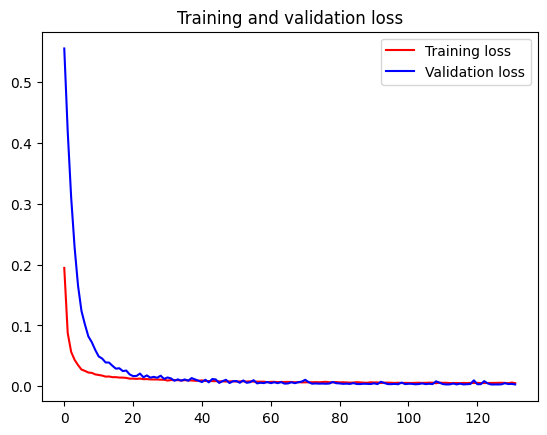

<Figure size 640x480 with 0 Axes>

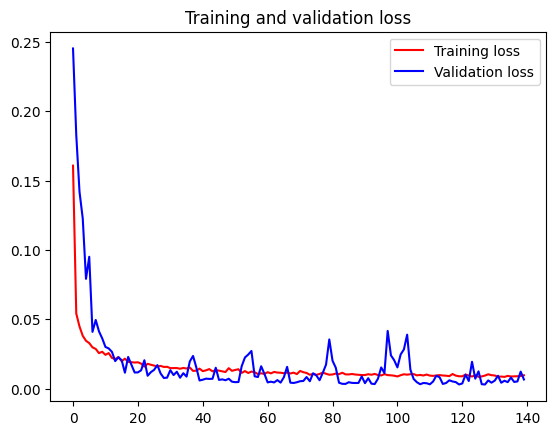

<Figure size 640x480 with 0 Axes>

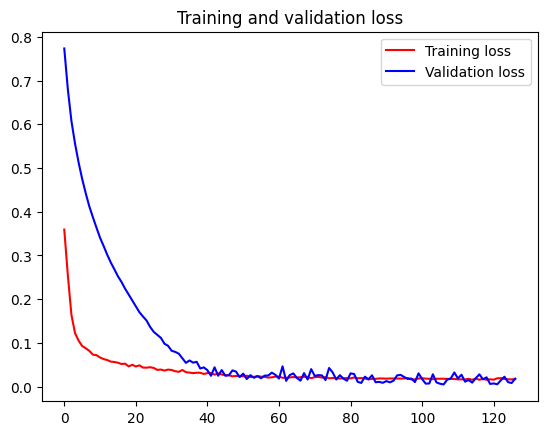

<Figure size 640x480 with 0 Axes>

(                  close          low         high
 rmse_train  1293.610831  1138.748040   949.084858
 rmse_test   1978.432459  1669.714829  1376.759304
 r2_train       0.992530     0.993845     0.996188
 r2_test        0.942935     0.955640     0.974724,
                   close          low         high
 rmse_train  1428.110545  1292.116848  1154.924680
 rmse_test   2740.491984  2560.963117  2299.216243
 r2_train       0.990896     0.992075     0.994355
 r2_test        0.890507     0.895645     0.929506,
                   close          low         high
 rmse_train  1945.881356  1836.961511  1757.267456
 rmse_test   4464.599083  4132.225247  4096.945361
 r2_train       0.983099     0.983982     0.986932
 r2_test        0.709401     0.728309     0.776173)

In [45]:
start_date = '2020-01-01'
train_end_date = '2024-01-01'
np.random.seed(42)
tf.random.set_seed(42)
time_step = 30
history_1, history_2, history_3, model_1, model_2, model_3, eval_1, eval_2, eval_3 = build_models(start_date, train_end_date, time_step)
plot_history(history_1)
plot_history(history_2)
plot_history(history_3)
model_1.save('model_1.keras')
model_2.save('model_2.keras')
model_3.save('model_3.keras')

eval_1, eval_2, eval_3

In [31]:
time_step = 30
date1 = '2024-04-21'
date2 = '2024-04-28'
date3 = '2024-05-05'
result1 = predict_next_7_days(time_step, model_1, date1)
result2 = predict_next_7_days(time_step, model_1, date2)
result3 = predict_next_7_days(time_step, model_1, date3)

result1, result2, result3

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


(['[64311.953 62247.57  65423.465]',
  '[63244.586 61180.16  64353.254]',
  '[62165.676 60131.35  63250.082]',
  '[61120.117 59128.086 62171.426]',
  '[60112.52  58167.773 61129.836]',
  '[59139.285 57243.375 60124.67 ]',
  '[58195.426 56348.234 59151.555]'],
 ['[62668.414 60666.31  63728.25 ]',
  '[61649.1   59667.027 62691.934]',
  '[60618.977 58673.47  61641.766]',
  '[59608.492 57705.42  60606.48 ]',
  '[58625.54  56767.383 59597.23 ]',
  '[57671.527 55859.062 58617.02 ]',
  '[56745.312 54978.387 57665.29 ]'],
 ['[63247.574 61252.957 64331.914]',
  '[62191.246 60187.55  63279.598]',
  '[61124.14 59144.66 62187.54]',
  '[60093.344 58152.86  61121.65 ]',
  '[59103.746 57208.625 60096.19 ]',
  '[58150.887 56303.35  59110.15 ]',
  '[57228.727 55428.97  58158.113]'])

In [32]:
result1 = predict_next_7_days(time_step, model_2, date1)
result2 = predict_next_7_days(time_step, model_2, date2)
result3 = predict_next_7_days(time_step, model_2, date3)

result1, result2, result3

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


(['[61473.824 59286.613 62578.363]',
  '[59472.727 57429.05  60540.656]',
  '[56779.164 54926.344 57776.55 ]',
  '[54199.727 52526.875 55122.527]',
  '[52015.11  50485.43  52872.293]',
  '[50222.82  48799.137 51026.016]',
  '[48725.355 47380.89  49484.27 ]'],
 ['[59910.203 57875.094 60969.586]',
  '[57976.12  56071.215 58992.55 ]',
  '[55619.418 53871.715 56572.21 ]',
  '[53366.207 51765.723 54254.598]',
  '[51400.75  49920.727 52232.016]',
  '[49723.97  48337.816 50506.875]',
  '[48272.98  46961.426 49014.926]'],
 ['[61165.574 58999.387 62247.65 ]',
  '[59341.73  57307.59  60397.176]',
  '[56611.434 54776.14  57599.145]',
  '[53940.17  52296.414 54852.92 ]',
  '[51680.28  50188.066 52526.477]',
  '[49847.246 48464.54  50638.99 ]',
  '[48339.27  47035.348 49086.902]'])

In [49]:
def predict_next_cycle_new(time_step,model, input_for_prediction, cycleLength):
  result = None
  for i in range(cycleLength):
    if(i != 0):
      array_reshaped = input_for_prediction.reshape(time_step, 3)
      array_appended = np.vstack([array_reshaped, predicted_value])
      array_final = array_appended[1:]
      input_for_prediction = array_final.reshape(1, time_step, 3)
    predicted_value = model.predict(input_for_prediction)
    ans = scaler.inverse_transform(predicted_value)
    #print(ans[0])
    if result is None:
      result = ans[0]
    else:
      result = np.vstack([result, ans[0]])
    #result.append((ans[0]))
  return result, sum(result[:,0])/7, min(result[:,1]), max(result[:,2])

def predict_next_7_days_new(time_step, model, input_date):
    input_for_prediction = get_past_data(time_step, input_date)
    result, close_avg, min_low, max_high = predict_next_cycle_new(time_step, model, input_for_prediction, 7)
    return result, close_avg, min_low, max_high

In [51]:
model_3 = tf.keras.models.load_model('model_3_new.keras')
result, close_avg, min_low, max_high = predict_next_7_days_new(time_step, model_3, date1)
result, close_avg, min_low, max_high

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


(array([[64056.895, 61981.785, 65051.656],
        [63996.2  , 61922.07 , 64988.637],
        [63917.688, 61847.4  , 64909.2  ],
        [63807.445, 61742.844, 64798.332],
        [63683.164, 61624.94 , 64673.53 ],
        [63556.645, 61504.82 , 64546.457],
        [63434.617, 61388.867, 64423.754]], dtype=float32),
 63778.95033482143,
 61388.867,
 65051.656)

In [52]:
result, close_avg, min_low, max_high = predict_next_7_days_new(time_step, model_3, date2)
result, close_avg, min_low, max_high

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


(array([[63604.023, 61551.203, 64601.582],
        [63409.258, 61364.684, 64404.367],
        [63278.34 , 61239.57 , 64270.984],
        [63181.574, 61147.137, 64171.79 ],
        [63104.082, 61073.21 , 64092.125],
        [63037.043, 61009.367, 64023.223],
        [62975.062, 60950.42 , 63959.688]], dtype=float32),
 63227.0546875,
 60950.42,
 64601.582)

In [53]:
result, close_avg, min_low, max_high = predict_next_7_days_new(time_step, model_3, date3)
result, close_avg, min_low, max_high

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


(array([[62701.688, 60691.97 , 63675.   ],
        [62821.59 , 60803.83 , 63794.55 ],
        [62870.164, 60850.19 , 63844.03 ],
        [62851.617, 60833.086, 63826.57 ],
        [62797.625, 60782.24 , 63773.605],
        [62728.754, 60717.1  , 63705.516],
        [62656.723, 60648.785, 63633.973]], dtype=float32),
 62775.451450892855,
 60648.785,
 63844.03)

In [63]:
maindf = pd.read_csv('BTC_USD.csv')
maindf = maindf.reset_index()
maindf['Date'] = pd.to_datetime(maindf['Date'], format='%Y-%m-%d')
maindf = maindf.drop(columns=['Open','Volume', 'Dividends', 'Stock Splits'])

def actual_values(input_date):
    date_object = dt.datetime.strptime(input_date, '%Y-%m-%d').date()
    end_window = date_object + timedelta(days=7)
    maindf_sub = maindf.loc[(maindf['Date'] >= input_date) & (maindf['Date'] < str(end_window))]
    maindf_sub = maindf_sub.reset_index(drop=True)
    close_avg = round(maindf_sub['Close'].mean(),2)
    min_low = round(maindf_sub['Low'].min(),2)
    max_high = round(maindf_sub['High'].max(),2)
    return close_avg, min_low, max_high



In [64]:
actual_values(date1)

(64872.09, 62424.72, 67233.96)

In [65]:
actual_values(date2)

(61678.57, 56555.29, 64703.33)

In [66]:
actual_values(date3)

(62193.18, 60208.78, 65494.9)

In [67]:
preds = [np.round(close_avg,2), np.round(min_low,2), np.round(max_high,2)]
actual = list(actual_values(date3))
math.sqrt(mean_squared_error(preds,actual))

1042.1143703433142

In [68]:
model_1.summary()

Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_30 (LSTM)                       │ (None, 16)                  │           1,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_30 (Dropout)                 │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 3)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,995 (15.61 KB)

 Trainable params: 1,331 (5.20 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,664 (10.41 KB)

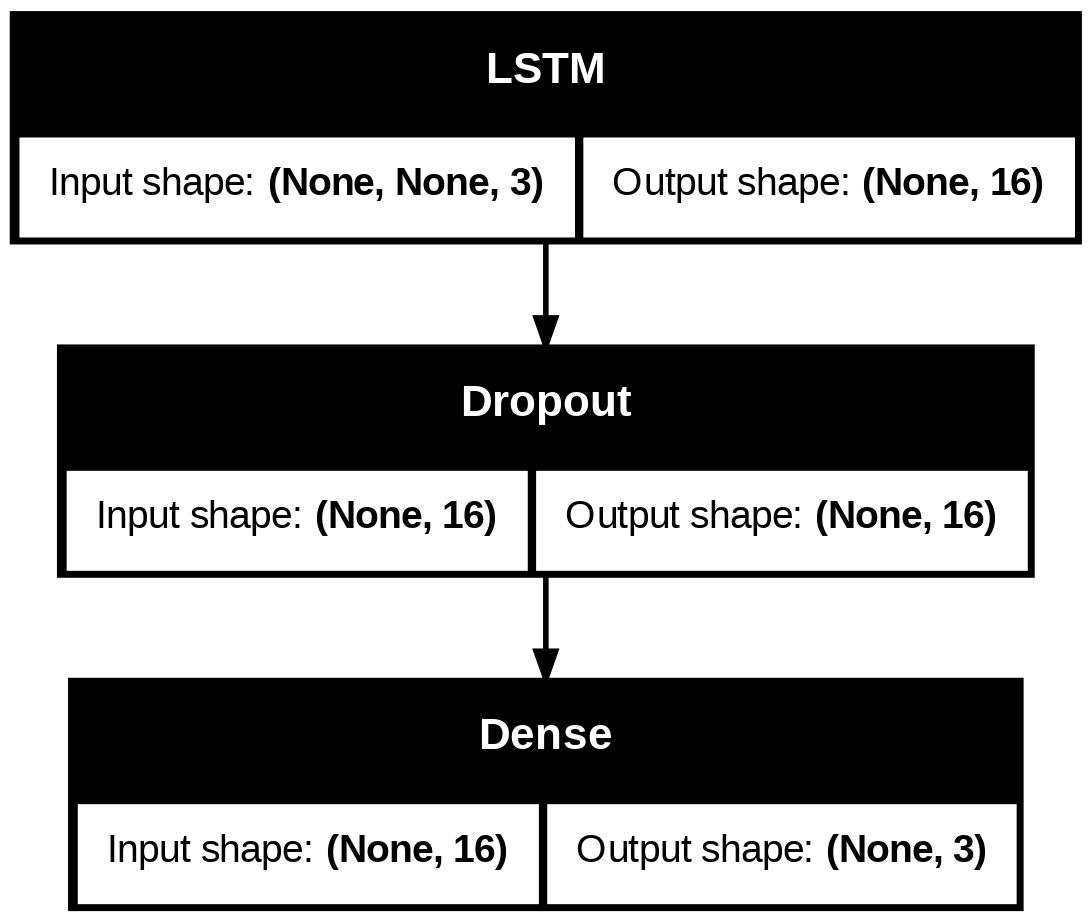

In [72]:
from keras.utils import plot_model
plot_model(model_1, to_file="model_1.png", show_shapes=True)

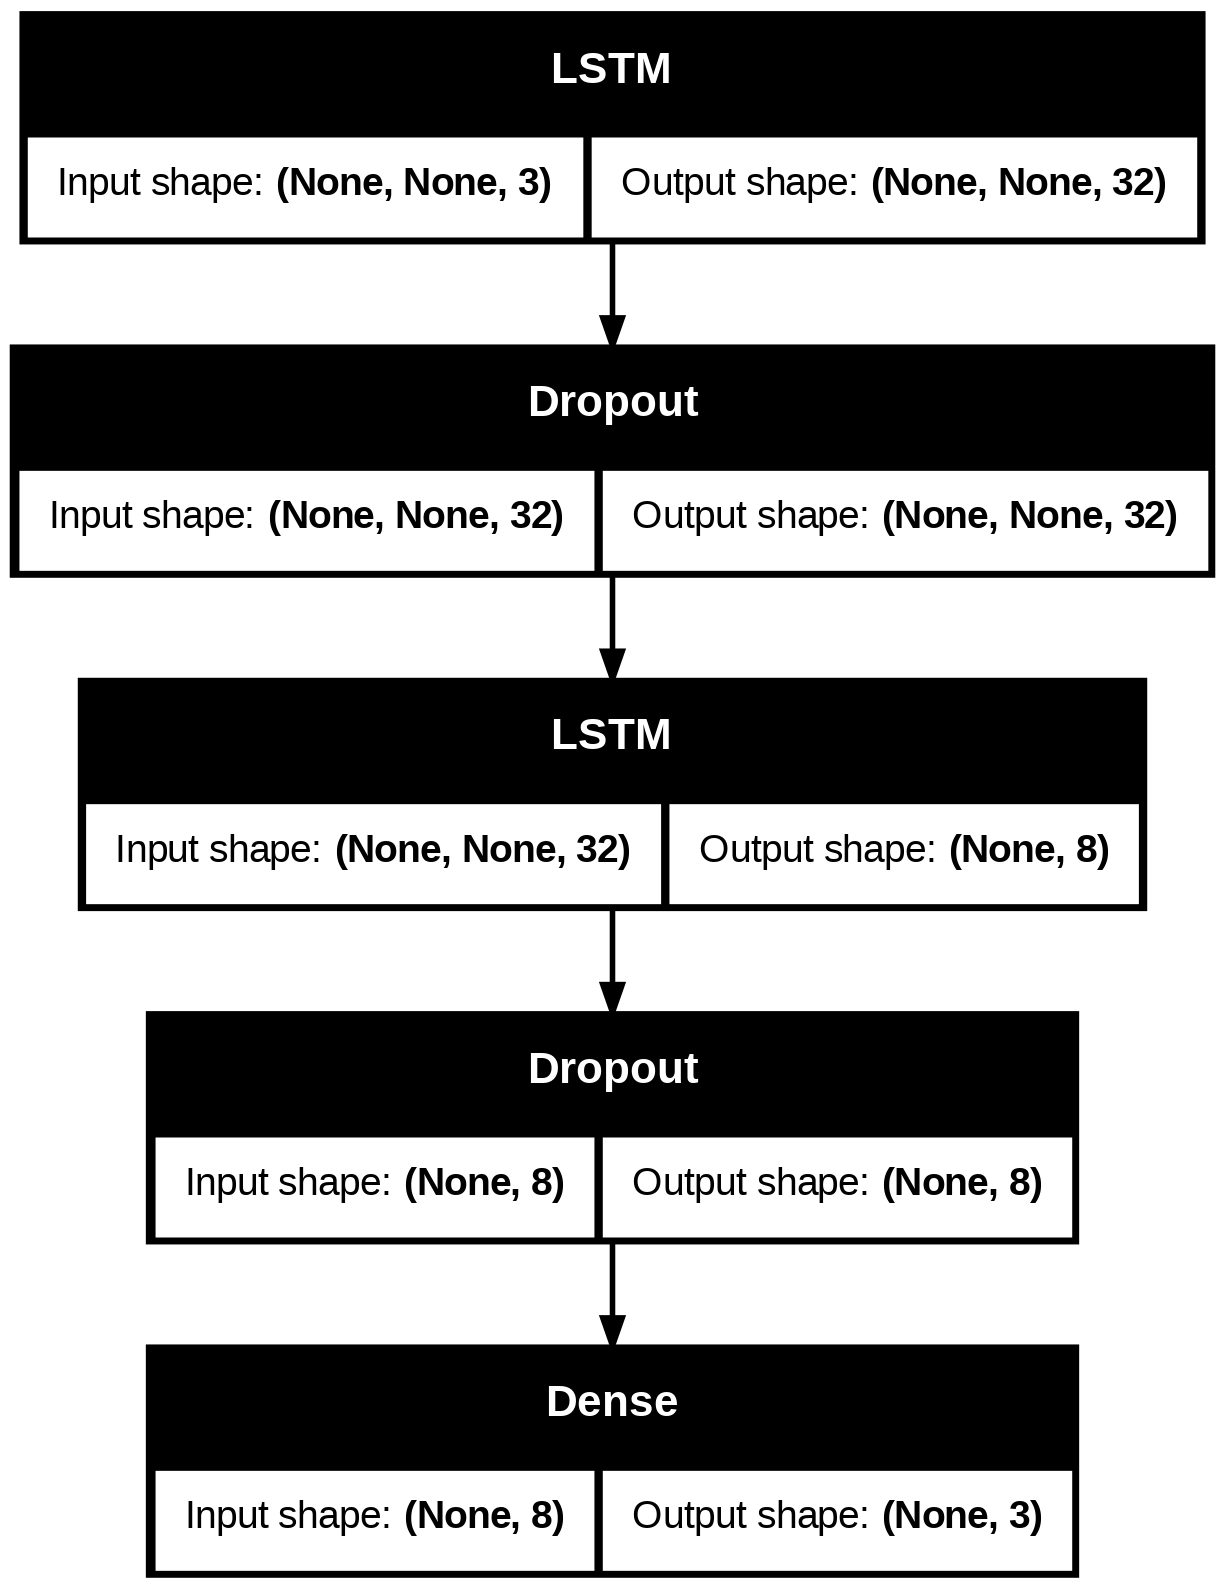

In [74]:
plot_model(model_2, to_file="model_2.png", show_shapes=True)

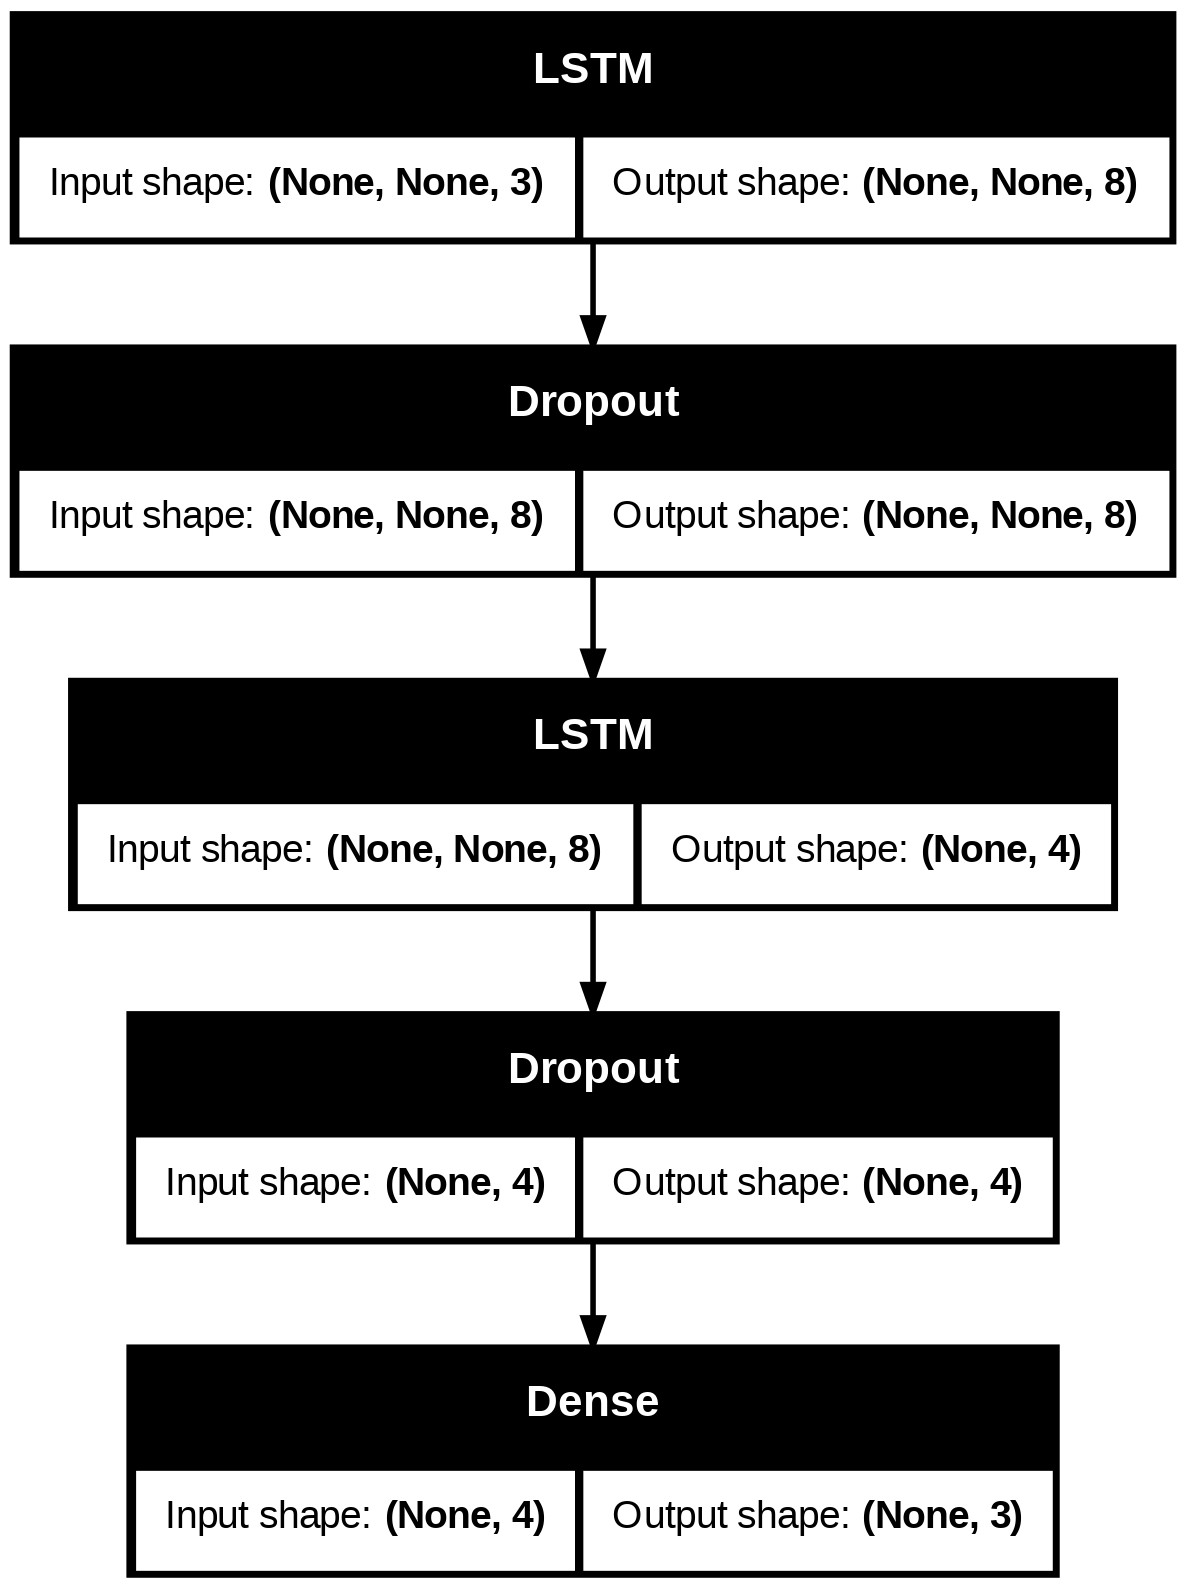

In [75]:
plot_model(model_3, to_file="model_3.png", show_shapes=True)